In [1]:
!nvidia-smi

Sat Mar 11 07:14:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    48W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports

In [2]:
!pip install -q tensorflow==2.11.0
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.4 MB/s eta 0:00:00


In [3]:
# Log in to your W&B account
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
import numpy as np
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras import mixed_precision
from typing import Tuple
from matplotlib import pyplot as plt

# Set seed for reproducibility.
tf.keras.utils.set_random_seed(42)

AUTO = tf.data.AUTOTUNE

# Configurations

In [5]:
config = {
    "mixed_precision": True,
    "dataset": "cifar10",
    "train_slice": 40_000,
    "batch_size": 1024,
    "buffer_size": 1024 * 2,
    "input_shape": [32, 32, 3],
    "image_size": 48,
    "num_classes": 10,
    "learning_rate": 1e-4,
    "weight_decay": 1e-4,
    "epochs": 100,
    "patch_size": 4,
    "embed_dim": 128,
    "chunk_size": 8,
    "r": 2,
    "num_layers": 6,
    "ffn_drop": 0.2,
    "attn_drop": 0.2,
    "num_heads": 1,
}

In [6]:
print(tf.__version__)

2.11.0


In [7]:
policy = mixed_precision.Policy("mixed_float16")
mixed_precision.set_global_policy(policy)

# Datasets

In [8]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
(x_train, y_train), (x_val, y_val) = (
    (x_train[: config["train_slice"]], y_train[: config["train_slice"]]),
    (x_train[config["train_slice"] :], y_train[config["train_slice"] :]),
)

170498071/170498071 [==============================] - 6s 0us/step


In [9]:
# Build the `train` augmentation pipeline.
train_aug = keras.Sequential(
    [
        layers.Rescaling(1 / 255.0, dtype="float32"),
        layers.Resizing(
            config["input_shape"][0] + 20,
            config["input_shape"][0] + 20,
            dtype="float32",
        ),
        layers.RandomCrop(config["image_size"], config["image_size"], dtype="float32"),
        layers.RandomFlip("horizontal", dtype="float32"),
    ],
    name="train_data_augmentation",
)

# Build the `val` and `test` data pipeline.
test_aug = keras.Sequential(
    [
        layers.Rescaling(1 / 255.0, dtype="float32"),
        layers.Resizing(config["image_size"], config["image_size"], dtype="float32"),
    ],
    name="test_data_augmentation",
)

In [10]:
def train_map_fn(image, label):
    return train_aug(image), label


def test_map_fn(image, label):
    return test_aug(image), label

In [11]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = (
    train_ds.map(train_map_fn, num_parallel_calls=AUTO)
    .shuffle(config["buffer_size"])
    .batch(config["batch_size"], num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = (
    val_ds.map(test_map_fn, num_parallel_calls=AUTO)
    .batch(config["batch_size"], num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = (
    test_ds.map(test_map_fn, num_parallel_calls=AUTO)
    .batch(config["batch_size"], num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

In [12]:
total_batches_train = tf.data.experimental.cardinality(train_ds).numpy()
total_batches_train

40

In [13]:
for image, label in train_ds.take(1):
    print(image.shape)
    print(label.shape)

(1024, 48, 48, 3)
(1024, 1)


# PatchEmbedding

In [14]:
class PatchEmbed(layers.Layer):
    """Image patch embedding layer.

    Args:
        image_size (Tuple[int]): Input image resolution.
        patch_size (Tuple[int]): Patch spatial resolution.
        embed_dim (int): Embedding dimension.
        add_pos_info (bool): Whether to add positional information to tokens.
    """

    def __init__(
        self,
        image_size: Tuple[int] = (48, 48),
        patch_size: Tuple[int] = (4, 4),
        embed_dim: int = 32,
        chunk_size: int = 8,
        **kwargs,
    ):
        super().__init__(**kwargs)
        patch_resolution = [
            image_size[0] // patch_size[0],
            image_size[1] // patch_size[1],
        ]
        self.image_size = image_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.patch_resolution = patch_resolution
        self.num_patches = patch_resolution[0] * patch_resolution[1]
        self.proj = layers.Conv2D(
            filters=embed_dim, kernel_size=patch_size, strides=patch_size
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=embed_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)
        self.norm = keras.layers.LayerNormalization(epsilon=1e-5)
        self.chunking_layer = layers.Reshape(
            target_shape=(self.num_patches // chunk_size, chunk_size, embed_dim)
        )

    def call(self, x: tf.Tensor) -> Tuple[tf.Tensor, int, int, int]:
        """Patchifies the image, converts into tokens and adds pos information.

        Args:
            x: Tensor of shape (B, H, W, C)

        Returns:
            A tuple of the processed tensor, height of the projected
            feature map, width of the projected feature map, number
            of channels of the projected feature map.
        """
        # Project the inputs.
        x = self.proj(x)
        x = self.flatten(x)
        x = x + self.position_embedding(self.positions)

        # B, H, W, C -> B, H*W, C
        x = self.norm(x)

        # Chunk the tokens in K
        x = self.chunking_layer(x)

        return x

# FFN

In [15]:
class FeedForwardNetwork(layers.Layer):
    """Feed Forward Network.

    Args:
        dims (`int`): Dimension of the FFN.
        dropout (`float`): Dropout probability of FFN.
    """

    def __init__(self, dims: int, dropout: float = 0.1, **kwargs):
        super().__init__(**kwargs)
        self.ffn = keras.Sequential(
            [
                layers.Dense(units=4 * dims, activation=tf.nn.gelu),
                layers.Dense(units=dims),
                layers.Dropout(rate=dropout),
            ]
        )
        self.add = layers.Add()
        self.layernorm = layers.LayerNormalization(epsilon=1e-5)

    def call(self, inputs: tf.Tensor):
        x = self.layernorm(inputs)
        x = self.add([inputs, self.ffn(x)])
        return x

# Attention

In [16]:
class BaseAttention(layers.Layer):
    """The base attention module.

    Args:
        num_heads (`int`): Number of attention heads.
        key_dim (`int`): Size of each attention head for query and key.
        dropout (`float`): Dropout probability for Attention Module.

    """

    def __init__(self, num_heads: int, key_dim: int, dropout: float = 0.1, **kwargs):
        super().__init__(**kwargs)
        self.mha = layers.MultiHeadAttention(num_heads, key_dim, dropout=dropout)
        self.q_layernorm = layers.LayerNormalization(epsilon=1e-5)
        self.k_layernorm = layers.LayerNormalization(epsilon=1e-5)
        self.v_layernorm = layers.LayerNormalization(epsilon=1e-5)
        self.add = layers.Add()

    def call(self, input_query: tf.Tensor, key: tf.Tensor, value: tf.Tensor):
        query = self.q_layernorm(input_query)
        key = self.k_layernorm(key)
        value = self.v_layernorm(value)
        (attn_outs, attn_scores) = self.mha(
            query=query,
            key=key,
            value=value,
            return_attention_scores=True,
        )
        self.attn_scores = attn_scores
        x = self.add([input_query, attn_outs])
        return x

In [17]:
class AttentionWithFFN(layers.Layer):
    """Self-attention module with FFN

    Args:
        ffn_dims (`int`): Number of units in FFN.
        ffn_dropout (`float`): Dropout probability for FFN.
        num_heads (`int`): Number of attention heads.
        key_dim (`int`): Size of each attention head for query and key.
        attn_dropout (`float`): Dropout probability for attention module.
    """

    def __init__(
        self,
        ffn_dims: int = 128,
        ffn_dropout: float = 0.1,
        num_heads: int = 4,
        key_dim: int = 256,
        attn_dropout: float = 0.1,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.attention = BaseAttention(
            num_heads, key_dim, attn_dropout, name="BaseAttention"
        )
        self.ffn = FeedForwardNetwork(ffn_dims, ffn_dropout, name="FeedForward")

    def call(self, query: tf.Tensor, key: tf.Tensor, value: tf.Tensor):
        x = self.attention(query, key, value)
        self.attn_scores = self.attention.attn_scores
        x = self.ffn(x)
        return x

# Recurrence

In [18]:
class CustomCell(layers.Layer):
    """Custom logic inside each recurrence.

    Args:
        chunk_size (`int`): Chunk size of the inputs.
        r (`int`): One Cross Attention per **r** Self Attention.
        num_layers (`int`): Number of layers in the Perceptual Model.
        ffn_dims (`int`): Number of units in FFN.
        ffn_dropout (`float`): Dropout probability for FFN.
        num_heads (`int`): Number of attention heads.
        key_dim (`int`): Size of each attention head for query and key.
        attn_dropout (`float`): Dropout probability for attention module.
    """

    def __init__(
        self,
        chunk_size,
        r=2,
        num_layers: int = 5,
        ffn_dims: int = 128,
        ffn_dropout: float = 0.1,
        num_heads: int = 4,
        key_dim: int = 256,
        attn_dropout: float = 0.1,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.chunk_size = chunk_size
        self.r = r
        self.num_layers = num_layers
        self.ffn_dims = ffn_dims
        self.ffn_droput = ffn_dropout
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.attn_dropout = attn_dropout

        self.state_size = tf.TensorShape([chunk_size, ffn_dims])
        self.output_size = tf.TensorShape([chunk_size, ffn_dims])

        self.get_attn_scores = False
        self.attn_scores = []

        ########################################################################
        # Perceptual Module
        ########################################################################
        perceptual_module = list()
        for layer_idx in range(num_layers):
            perceptual_module.append(
                AttentionWithFFN(
                    ffn_dims=ffn_dims,
                    ffn_dropout=ffn_dropout,
                    num_heads=num_heads,
                    key_dim=key_dim,
                    attn_dropout=attn_dropout,
                    name=f"PM_SelfAttentionFFN{layer_idx}",
                )
            )
            if layer_idx % r == 0:
                perceptual_module.append(
                    AttentionWithFFN(
                        ffn_dims=ffn_dims,
                        ffn_dropout=ffn_dropout,
                        num_heads=num_heads,
                        key_dim=key_dim,
                        attn_dropout=attn_dropout,
                        name=f"PM_CrossAttentionFFN{layer_idx}",
                    )
                )
        self.perceptual_module = perceptual_module

        ########################################################################
        # Temporal Latent Bottleneck Module
        ########################################################################
        self.tlb_module = AttentionWithFFN(
            ffn_dims=ffn_dims,
            ffn_dropout=ffn_dropout,
            num_heads=num_heads,
            key_dim=key_dim,
            attn_dropout=attn_dropout,
            name=f"TLBM_CrossAttentionFFN",
        )

    def call(self, inputs, states, training=None):
        # inputs => (batch, chunk_size, dims)
        # states => [(batch, chunk_size, units)]

        slow_stream = states[0]
        fast_stream = inputs

        for layer_idx, layer in enumerate(self.perceptual_module):
            fast_stream = layer(query=fast_stream, key=fast_stream, value=fast_stream)

            if layer_idx % self.r == 0:
                fast_stream = layer(
                    query=fast_stream, key=slow_stream, value=slow_stream
                )

        slow_stream = self.tlb_module(
            query=slow_stream, key=fast_stream, value=fast_stream
        )

        if self.get_attn_scores:
            self.attn_scores.append(self.tlb_module.attn_scores)

        return fast_stream, [slow_stream]

# Build the model

In [19]:
class ModelTrainer(keras.Model):
    def __init__(self, patch_layer, custom_cell, **kwargs):
        super().__init__(**kwargs)
        self.patch_layer = patch_layer
        self.rnn = layers.RNN(custom_cell)
        self.gap = layers.GlobalAveragePooling1D()
        self.head = layers.Dense(10, activation="softmax", dtype="float32")

    def call(self, inputs):
        x = self.patch_layer(inputs)
        x = self.rnn(x)
        x = self.gap(x)
        outputs = self.head(x)
        return outputs

In [20]:
keras.backend.clear_session()

# PATCH
patch_layer = PatchEmbed(
    image_size=(config["image_size"], config["image_size"]),
    patch_size=(config["patch_size"], config["patch_size"]),
    embed_dim=config["embed_dim"],
    chunk_size=config["chunk_size"],
)

# RECURRENCE
cell = CustomCell(
    chunk_size=config["chunk_size"],
    r=config["r"],
    num_layers=config["num_layers"],
    ffn_dims=config["embed_dim"],
    ffn_dropout=config["ffn_drop"],
    num_heads=config["num_heads"],
    key_dim=config["embed_dim"],
    attn_dropout=config["attn_drop"],
)


model = ModelTrainer(patch_layer, cell)

In [21]:
run = wandb.init(
    project="temporal-latent-bottleneck",
    entity="ariG23498",
    config=config,
    name="cifar10-100epochs",
)

# # Train the 20 epoch model some more
# artifact = run.use_artifact(
#     'arig23498/temporal-latent-bottleneck/run_7081udud_model:v1',
#     type='model'
# )
# artifact_dir = artifact.download()
# model.load_weights(artifact_dir)

optimizer = AdamW(
    learning_rate=config["learning_rate"], weight_decay=config["weight_decay"]
)
wandb_callbacks = [
    WandbMetricsLogger(),
    WandbModelCheckpoint(
        filepath="model_{epoch:02d}",
        save_freq=int(10 * total_batches_train),
    ),
]
# Compile and train the model.
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds,
    epochs=config["epochs"],
    validation_data=val_ds,
    callbacks=wandb_callbacks,
)

run.finish()

wandb: Currently logged in as: arig23498. Use `wandb login --relogin` to force relogin


Epoch 1/100
40/40 [==============================] - 211s 3s/step - loss: 2.9351 - accuracy: 0.1434 - val_loss: 2.1893 - val_accuracy: 0.2061
Epoch 2/100
40/40 [==============================] - 78s 2s/step - loss: 2.1292 - accuracy: 0.2238 - val_loss: 2.0301 - val_accuracy: 0.2660
Epoch 3/100
40/40 [==============================] - 79s 2s/step - loss: 2.0539 - accuracy: 0.2494 - val_loss: 2.0199 - val_accuracy: 0.2585
Epoch 4/100
40/40 [==============================] - 78s 2s/step - loss: 1.9979 - accuracy: 0.2692 - val_loss: 1.9417 - val_accuracy: 0.3129
Epoch 5/100
40/40 [==============================] - 78s 2s/step - loss: 1.9364 - accuracy: 0.2964 - val_loss: 1.8780 - val_accuracy: 0.3275
Epoch 6/100
40/40 [==============================] - 78s 2s/step - loss: 1.8889 - accuracy: 0.3106 - val_loss: 1.8020 - val_accuracy: 0.3473
Epoch 7/100
40/40 [==============================] - 78s 2s/step - loss: 1.8074 - accuracy: 0.3383 - val_loss: 1.8039 - val_accuracy: 0.3583
Epoch 8/100


wandb: Adding directory to artifact (./model_10)... Done. 0.1s


40/40 [==============================] - 142s 4s/step - loss: 1.6412 - accuracy: 0.3972 - val_loss: 1.6166 - val_accuracy: 0.4231
Epoch 11/100
40/40 [==============================] - 78s 2s/step - loss: 1.6029 - accuracy: 0.4100 - val_loss: 1.5845 - val_accuracy: 0.4394
Epoch 12/100
40/40 [==============================] - 78s 2s/step - loss: 1.5562 - accuracy: 0.4302 - val_loss: 1.5047 - val_accuracy: 0.4587
Epoch 13/100
40/40 [==============================] - 78s 2s/step - loss: 1.5230 - accuracy: 0.4405 - val_loss: 1.4986 - val_accuracy: 0.4640
Epoch 14/100
40/40 [==============================] - 78s 2s/step - loss: 1.4878 - accuracy: 0.4508 - val_loss: 1.5346 - val_accuracy: 0.4602
Epoch 15/100
40/40 [==============================] - 78s 2s/step - loss: 1.4644 - accuracy: 0.4620 - val_loss: 1.4576 - val_accuracy: 0.4715
Epoch 16/100
40/40 [==============================] - 78s 2s/step - loss: 1.4537 - accuracy: 0.4669 - val_loss: 1.4215 - val_accuracy: 0.4865
Epoch 17/100
40/40

wandb: Adding directory to artifact (./model_20)... Done. 0.1s


40/40 [==============================] - 142s 4s/step - loss: 1.3525 - accuracy: 0.5058 - val_loss: 1.3402 - val_accuracy: 0.5231
Epoch 21/100
40/40 [==============================] - 78s 2s/step - loss: 1.3315 - accuracy: 0.5144 - val_loss: 1.3285 - val_accuracy: 0.5205
Epoch 22/100
40/40 [==============================] - 78s 2s/step - loss: 1.3102 - accuracy: 0.5229 - val_loss: 1.3034 - val_accuracy: 0.5319
Epoch 23/100
40/40 [==============================] - 78s 2s/step - loss: 1.3023 - accuracy: 0.5235 - val_loss: 1.2869 - val_accuracy: 0.5385
Epoch 24/100
40/40 [==============================] - 79s 2s/step - loss: 1.2768 - accuracy: 0.5351 - val_loss: 1.3118 - val_accuracy: 0.5318
Epoch 25/100
40/40 [==============================] - 78s 2s/step - loss: 1.2706 - accuracy: 0.5370 - val_loss: 1.2713 - val_accuracy: 0.5451
Epoch 26/100
40/40 [==============================] - 78s 2s/step - loss: 1.2396 - accuracy: 0.5494 - val_loss: 1.2531 - val_accuracy: 0.5516
Epoch 27/100
40/40

wandb: Adding directory to artifact (./model_30)... Done. 0.1s


40/40 [==============================] - 144s 4s/step - loss: 1.1904 - accuracy: 0.5666 - val_loss: 1.1835 - val_accuracy: 0.5763
Epoch 31/100
40/40 [==============================] - 78s 2s/step - loss: 1.1714 - accuracy: 0.5768 - val_loss: 1.1880 - val_accuracy: 0.5745
Epoch 32/100
40/40 [==============================] - 79s 2s/step - loss: 1.1564 - accuracy: 0.5812 - val_loss: 1.2861 - val_accuracy: 0.5438
Epoch 33/100
40/40 [==============================] - 78s 2s/step - loss: 1.1711 - accuracy: 0.5783 - val_loss: 1.2441 - val_accuracy: 0.5627
Epoch 34/100
40/40 [==============================] - 79s 2s/step - loss: 1.1534 - accuracy: 0.5818 - val_loss: 1.2373 - val_accuracy: 0.5670
Epoch 35/100
40/40 [==============================] - 78s 2s/step - loss: 1.1428 - accuracy: 0.5880 - val_loss: 1.1459 - val_accuracy: 0.5914
Epoch 36/100
40/40 [==============================] - 78s 2s/step - loss: 1.1127 - accuracy: 0.5981 - val_loss: 1.2172 - val_accuracy: 0.5708
Epoch 37/100
40/40

wandb: Adding directory to artifact (./model_40)... Done. 0.1s


40/40 [==============================] - 143s 4s/step - loss: 1.0718 - accuracy: 0.6134 - val_loss: 1.1278 - val_accuracy: 0.6020
Epoch 41/100
40/40 [==============================] - 78s 2s/step - loss: 1.0583 - accuracy: 0.6177 - val_loss: 1.1094 - val_accuracy: 0.6046
Epoch 42/100
40/40 [==============================] - 78s 2s/step - loss: 1.0447 - accuracy: 0.6234 - val_loss: 1.1020 - val_accuracy: 0.6060
Epoch 43/100
40/40 [==============================] - 79s 2s/step - loss: 1.0345 - accuracy: 0.6266 - val_loss: 1.1231 - val_accuracy: 0.6077
Epoch 44/100
40/40 [==============================] - 78s 2s/step - loss: 1.0330 - accuracy: 0.6309 - val_loss: 1.0979 - val_accuracy: 0.6114
Epoch 45/100
40/40 [==============================] - 79s 2s/step - loss: 1.0291 - accuracy: 0.6274 - val_loss: 1.0556 - val_accuracy: 0.6255
Epoch 46/100
40/40 [==============================] - 79s 2s/step - loss: 1.0081 - accuracy: 0.6376 - val_loss: 1.1163 - val_accuracy: 0.6142
Epoch 47/100
40/40

wandb: Adding directory to artifact (./model_50)... Done. 0.1s


40/40 [==============================] - 143s 4s/step - loss: 0.9793 - accuracy: 0.6492 - val_loss: 1.0486 - val_accuracy: 0.6307
Epoch 51/100
40/40 [==============================] - 78s 2s/step - loss: 0.9786 - accuracy: 0.6500 - val_loss: 1.0567 - val_accuracy: 0.6293
Epoch 52/100
40/40 [==============================] - 80s 2s/step - loss: 0.9667 - accuracy: 0.6536 - val_loss: 1.0311 - val_accuracy: 0.6331
Epoch 53/100
40/40 [==============================] - 79s 2s/step - loss: 0.9593 - accuracy: 0.6575 - val_loss: 1.0463 - val_accuracy: 0.6289
Epoch 54/100
40/40 [==============================] - 79s 2s/step - loss: 0.9529 - accuracy: 0.6597 - val_loss: 1.0175 - val_accuracy: 0.6374
Epoch 55/100
40/40 [==============================] - 79s 2s/step - loss: 0.9389 - accuracy: 0.6655 - val_loss: 1.0399 - val_accuracy: 0.6350
Epoch 56/100
40/40 [==============================] - 79s 2s/step - loss: 0.9360 - accuracy: 0.6636 - val_loss: 1.0858 - val_accuracy: 0.6206
Epoch 57/100
40/40

wandb: Adding directory to artifact (./model_60)... Done. 0.1s


40/40 [==============================] - 145s 4s/step - loss: 0.8975 - accuracy: 0.6778 - val_loss: 1.0048 - val_accuracy: 0.6515
Epoch 61/100
40/40 [==============================] - 79s 2s/step - loss: 0.8981 - accuracy: 0.6780 - val_loss: 0.9868 - val_accuracy: 0.6541
Epoch 62/100
40/40 [==============================] - 79s 2s/step - loss: 0.8863 - accuracy: 0.6812 - val_loss: 0.9786 - val_accuracy: 0.6552
Epoch 63/100
40/40 [==============================] - 79s 2s/step - loss: 0.8756 - accuracy: 0.6864 - val_loss: 0.9834 - val_accuracy: 0.6613
Epoch 64/100
40/40 [==============================] - 79s 2s/step - loss: 0.8723 - accuracy: 0.6894 - val_loss: 0.9779 - val_accuracy: 0.6628
Epoch 65/100
40/40 [==============================] - 79s 2s/step - loss: 0.8620 - accuracy: 0.6918 - val_loss: 0.9770 - val_accuracy: 0.6616
Epoch 66/100
40/40 [==============================] - 79s 2s/step - loss: 0.8522 - accuracy: 0.6977 - val_loss: 0.9678 - val_accuracy: 0.6643
Epoch 67/100
40/40

wandb: Adding directory to artifact (./model_70)... Done. 0.1s


40/40 [==============================] - 144s 4s/step - loss: 0.8329 - accuracy: 0.7016 - val_loss: 1.0046 - val_accuracy: 0.6522
Epoch 71/100
40/40 [==============================] - 79s 2s/step - loss: 0.8301 - accuracy: 0.7009 - val_loss: 0.9777 - val_accuracy: 0.6640
Epoch 72/100
40/40 [==============================] - 79s 2s/step - loss: 0.8270 - accuracy: 0.7035 - val_loss: 0.9746 - val_accuracy: 0.6641
Epoch 73/100
40/40 [==============================] - 79s 2s/step - loss: 0.8171 - accuracy: 0.7090 - val_loss: 0.9352 - val_accuracy: 0.6767
Epoch 74/100
40/40 [==============================] - 79s 2s/step - loss: 0.8073 - accuracy: 0.7124 - val_loss: 0.9623 - val_accuracy: 0.6718
Epoch 75/100
40/40 [==============================] - 78s 2s/step - loss: 0.7976 - accuracy: 0.7159 - val_loss: 0.9514 - val_accuracy: 0.6753
Epoch 76/100
40/40 [==============================] - 78s 2s/step - loss: 0.7923 - accuracy: 0.7185 - val_loss: 0.9322 - val_accuracy: 0.6755
Epoch 77/100
40/40

wandb: Adding directory to artifact (./model_80)... Done. 0.1s


40/40 [==============================] - 144s 4s/step - loss: 0.7578 - accuracy: 0.7308 - val_loss: 0.9243 - val_accuracy: 0.6866
Epoch 81/100
40/40 [==============================] - 78s 2s/step - loss: 0.7705 - accuracy: 0.7254 - val_loss: 0.9214 - val_accuracy: 0.6884
Epoch 82/100
40/40 [==============================] - 78s 2s/step - loss: 0.7497 - accuracy: 0.7324 - val_loss: 0.9126 - val_accuracy: 0.6868
Epoch 83/100
40/40 [==============================] - 79s 2s/step - loss: 0.7430 - accuracy: 0.7335 - val_loss: 0.9289 - val_accuracy: 0.6859
Epoch 84/100
40/40 [==============================] - 78s 2s/step - loss: 0.7474 - accuracy: 0.7337 - val_loss: 0.9077 - val_accuracy: 0.6913
Epoch 85/100
40/40 [==============================] - 78s 2s/step - loss: 0.7399 - accuracy: 0.7362 - val_loss: 0.9385 - val_accuracy: 0.6796
Epoch 86/100
40/40 [==============================] - 78s 2s/step - loss: 0.7370 - accuracy: 0.7351 - val_loss: 0.9495 - val_accuracy: 0.6818
Epoch 87/100
40/40

wandb: Adding directory to artifact (./model_90)... Done. 0.1s


40/40 [==============================] - 143s 4s/step - loss: 0.7057 - accuracy: 0.7487 - val_loss: 0.9188 - val_accuracy: 0.6872
Epoch 91/100
40/40 [==============================] - 78s 2s/step - loss: 0.7049 - accuracy: 0.7476 - val_loss: 0.8944 - val_accuracy: 0.6976
Epoch 92/100
40/40 [==============================] - 78s 2s/step - loss: 0.6930 - accuracy: 0.7505 - val_loss: 0.8921 - val_accuracy: 0.7036
Epoch 93/100
40/40 [==============================] - 79s 2s/step - loss: 0.6961 - accuracy: 0.7509 - val_loss: 0.9113 - val_accuracy: 0.6897
Epoch 94/100
40/40 [==============================] - 78s 2s/step - loss: 0.7066 - accuracy: 0.7490 - val_loss: 0.8835 - val_accuracy: 0.6995
Epoch 95/100
40/40 [==============================] - 78s 2s/step - loss: 0.6818 - accuracy: 0.7539 - val_loss: 0.8666 - val_accuracy: 0.7045
Epoch 96/100
40/40 [==============================] - 79s 2s/step - loss: 0.6712 - accuracy: 0.7589 - val_loss: 0.8773 - val_accuracy: 0.7061
Epoch 97/100
40/40

wandb: Adding directory to artifact (./model_100)... Done. 0.1s


40/40 [==============================] - 144s 4s/step - loss: 0.6624 - accuracy: 0.7631 - val_loss: 0.8752 - val_accuracy: 0.7074


epoch/accuracy,▁▂▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▂▃▃▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epoch/val_loss,█▇▆▆▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.76315
epoch/epoch,99
epoch/learning_rate,0.0001
epoch/loss,0.66236
epoch/val_accuracy,0.7074


# Testing

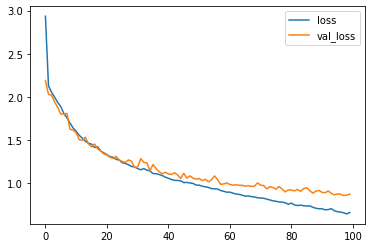

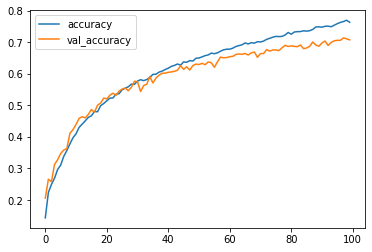

In [22]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

# Visualize the Latent Bottleneck

In [23]:
images, labels = next(iter(test_ds))

# Set the flag for attn score
model.rnn.cell.get_attn_scores = True
outputs = model(images)

In [24]:
# Grab the list of chunk scores
list_chunk_scores = model.rnn.cell.attn_scores

In [25]:
def score_to_viz(chunk_score):
    chunk_viz = tf.math.reduce_max(chunk_score, axis=-2)  # get the most attended token
    chunk_viz = tf.math.reduce_mean(chunk_viz, axis=1)  # get the mean across heads
    return chunk_viz

In [26]:
list_chunk_viz = [score_to_viz(x) for x in list_chunk_scores]

In [27]:
chunk_viz = tf.concat(list_chunk_viz[1:], axis=-1)
chunk_viz = tf.reshape(
    chunk_viz,
    (
        config["batch_size"],
        config["image_size"] // config["patch_size"],
        config["image_size"] // config["patch_size"],
        1,
    ),
)

In [28]:
upsampled_heat_map = layers.UpSampling2D(
    size=(4, 4), interpolation="bilinear", dtype="float32"
)(chunk_viz)

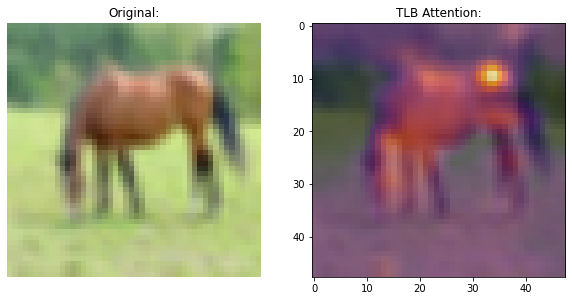

In [35]:
index = 60
orig_image = images[index]
overlay_image = upsampled_heat_map[index, ..., 0]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax[0].imshow(orig_image)
ax[0].set_title("Original:")
ax[0].axis("off")

image = ax[1].imshow(orig_image)
ax[1].imshow(
    overlay_image,
    cmap="inferno",
    alpha=0.6,
    extent=image.get_extent(),
)
ax[1].set_title("TLB Attention:")

plt.show()